In [311]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import scipy.stats as stats
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [240]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [241]:
df = pd.read_csv('dane.csv', sep=';', index_col=0)

In [242]:
df.head(10)

,Cel,Aktywa,Płeć,Stan cywilny,Mieszkanie,Praca,Okres,Wiek,Ocena
1,Drobne AGD,Bardzo niskie,M,Samotna(y),Własne,Fizyczny,13,23,Dobra
2,Meble,Niskie,M,Rozwiedziona(y),Własne,Umysłowy,25,32,Zła
3,Nowy samochód,Bardzo niskie,M,Samotna(y),Własne,Umysłowy,19,38,Zła
4,Meble,Bardzo niskie,M,Samotna(y),Własne,Fizyczny,13,36,Zła
5,Edukacja,Niskie,M,Samotna(y),Wynajem,Umysłowy,40,31,Dobra
6,Meble,Brak,M,Stały związek,Własne,Umysłowy,11,25,Dobra
7,Nowy samochód,Bardzo niskie,M,Stały związek,Własne,Fizyczny,13,26,Dobra
8,Business,Bardzo niskie,M,Samotna(y),Własne,Fizyczny,14,27,Dobra
9,Drobne AGD,Bardzo niskie,M,Samotna(y),Własne,Umysłowy,37,25,Zła
10,Drobne AGD,Brak,K,Rozwiedziona(y),Własne,Umysłowy,25,43,Zła


In [243]:
# Kodowanie zero jedynkowo
df['Płeć'] = df['Płeć'].apply(lambda x: 1 if x == 'M' else 0)

df['Stan cywilny'] = df['Stan cywilny'].apply(lambda x: 1 if x == 'Stały związek' else 0)

df['Mieszkanie'] = df['Mieszkanie'].apply(lambda x: 1 if x == 'Własne' else 0)

df['Praca'] = df['Praca'].apply(lambda x: 1 if x == 'Umysłowy' else 0)

df['Ocena'] = df['Ocena'].apply(lambda x: 1 if x == 'Dobra' else 0)

In [244]:
df.isna().any()

Cel             False
Aktywa          False
Płeć            False
Stan cywilny    False
Mieszkanie      False
Praca           False
Okres           False
Wiek            False
Ocena           False
dtype: bool

In [245]:
df.head(10)

,Cel,Aktywa,Płeć,Stan cywilny,Mieszkanie,Praca,Okres,Wiek,Ocena
1,Drobne AGD,Bardzo niskie,1,0,1,0,13,23,1
2,Meble,Niskie,1,0,1,1,25,32,0
3,Nowy samochód,Bardzo niskie,1,0,1,1,19,38,0
4,Meble,Bardzo niskie,1,0,1,0,13,36,0
5,Edukacja,Niskie,1,0,0,1,40,31,1
6,Meble,Brak,1,1,1,1,11,25,1
7,Nowy samochód,Bardzo niskie,1,1,1,0,13,26,1
8,Business,Bardzo niskie,1,0,1,0,14,27,1
9,Drobne AGD,Bardzo niskie,1,0,1,1,37,25,0
10,Drobne AGD,Brak,0,0,1,1,25,43,0


In [246]:
df.iloc[:,2:-1].columns

Index(['Płeć', 'Stan cywilny', 'Mieszkanie', 'Praca', 'Okres', 'Wiek'], dtype='object')

In [247]:
y = df['Ocena']
y


1      1
2      0
3      0
4      0
5      1
      ..
421    1
422    0
423    0
424    0
425    1
Name: Ocena, Length: 425, dtype: int64

In [248]:
def hosmer_lemeshow(y, y_pred_prob, n_bins=10):
    y = np.array(y)
    y_pred_prob = np.array(y_pred_prob)

    # Tworzymy biny dla prognozowanych prawdopodobieństw
    percentiles = np.percentile(y_pred_prob, np.linspace(0, 100, n_bins + 1))
    bins = np.digitize(y_pred_prob, percentiles[1:-1])
    
    # Liczymy rzeczywiste i oczekiwane proporcje sukcesów
    actual = np.bincount(bins, weights=y) / np.bincount(bins)
    expected = np.bincount(bins, weights=y_pred_prob) / np.bincount(bins)
    
    # Obliczamy statystykę testu Hosmera-Lemeshowa
    hl_stat = np.sum((actual - expected) ** 2 / (expected * (1 - expected) / np.bincount(bins)))
    
    # Obliczamy p-wartość
    p_value = stats.chi2.sf(hl_stat, n_bins - 2)
    
    return hl_stat, p_value

Testy

In [258]:
def evaluate(*args):
    evaluation = pd.DataFrame({
    'Column' : [],
    'Std dev' : [],
    'AIC' : [],
    'BIC' : [],
    'R2_Nagelkera' : [],
    'Odds ratio' : [],
    'Hosmel test' : [],
    'Hosmel p_value' : [],
    'Parameter significance' : [],
    })

    y = df['Ocena']
    
    args = list(args)

    for column in df.iloc[:,2:-1].drop(args, axis=1).columns:
        args.append(column)
        X = sm.add_constant(df[args])  # dodajemy stałą do modelu
        model = sm.Logit(y, X)
        results = model.fit()
        
        # Obliczanie p-wartości dla każdego parametru
        p_values = results.pvalues
        #print(f"P-wartości dla {column}: ", p_values)
        
        # Odchylenie
        std_dev = results.bse[column]
        
        # Obliczanie AIC, BIC, R-kwadrat Nagelkera
        AIC = results.aic
        BIC = results.bic
        R2_Nagelkera = results.prsquared

        # Test Hosmera-Lemeshowa 
        hl_stat, p_value = hosmer_lemeshow(y, results.predict(X))
        #print('Hosmer-Lemeshow test: H=%.3f, p=%.3f' % (hl_stat, p_value))
        
        # Iloraz szans
        odds_ratio = np.exp(results.params[column])
        
        #print(AIC, BIC, R2_Nagelkera, odds_ratio)
        new_data = pd.DataFrame({
            'Column' : [str(args)],
            'Std dev' : [std_dev],
            'AIC' : [AIC / 1000],
            'BIC' : [BIC / 1000],
            'R2_Nagelkera' : [R2_Nagelkera * 100],
            'Odds ratio' : [odds_ratio],
            'Hosmel test' : [hl_stat],
            'Hosmel p_value': [p_value],
            'Parameter significance': [p_values[1]],
        })    
        
        evaluation = pd.concat([evaluation, new_data], ignore_index=True)
        
        args.pop()
        
    
    return evaluation

In [259]:
res = evaluate()
res

Optimization terminated successfully.
         Current function value: 0.686949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693013
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692955
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.667892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689470
         Iterations 4


,Column,Std dev,AIC,BIC,R2_Nagelkera,Odds ratio,Hosmel test,Hosmel p_value,Parameter significance
0,['Płeć'],0.210363,0.587907,0.596011,0.890646,1.615354,NaN,NaN,0.022628
1,['Stan cywilny'],0.348910,0.593061,0.601166,0.015711,1.111916,NaN,NaN,0.761094
2,['Mieszkanie'],0.212633,0.584568,0.592672,1.457335,1.855106,NaN,NaN,0.003659
3,['Praca'],0.228849,0.593012,0.601116,0.024093,0.917414,NaN,NaN,0.706432
4,['Okres'],0.008601,0.571708,0.579813,3.640046,0.962479,NaN,NaN,0.000009
5,['Wiek'],0.008910,0.590049,0.598154,0.526942,1.015720,21.953839,0.005002,0.079999


In [260]:
res = evaluate('Okres')
res

Optimization terminated successfully.
         Current function value: 0.657460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664101
         Iterations 5


,Column,Std dev,AIC,BIC,R2_Nagelkera,Odds ratio,Hosmel test,Hosmel p_value,Parameter significance
0,"['Okres', 'Płeć']",0.219784,0.564841,0.576997,5.145202,1.911635,NaN,NaN,0.000002
1,"['Okres', 'Stan cywilny']",0.359362,0.573704,0.585860,3.640788,0.976516,NaN,NaN,0.000009
2,"['Okres', 'Mieszkanie']",0.218272,0.567821,0.579977,4.639422,1.694299,7.029375,0.533467,0.000030
3,"['Okres', 'Praca']",0.240826,0.573144,0.585300,3.735917,1.198282,14.920966,0.060701,0.000007
4,"['Okres', 'Wiek']",0.009215,0.570486,0.582643,4.186969,1.016541,10.490896,0.232246,0.000008


In [261]:
res = evaluate('Okres', 'Płeć')
res

Optimization terminated successfully.
         Current function value: 0.656789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655402
         Iterations 5


,Column,Std dev,AIC,BIC,R2_Nagelkera,Odds ratio,Hosmel test,Hosmel p_value,Parameter significance
0,"['Okres', 'Płeć', 'Stan cywilny']",0.371700,0.566270,0.582479,5.242034,0.754744,8.200308,0.414152,0.000002
1,"['Okres', 'Płeć', 'Mieszkanie']",0.222156,0.562889,0.579097,5.816004,1.553842,4.678788,0.791291,0.000007
2,"['Okres', 'Płeć', 'Praca']",0.243805,0.566297,0.582505,5.237513,1.196858,4.176011,0.840904,0.000002
3,"['Okres', 'Płeć', 'Wiek']",0.009372,0.565091,0.581300,5.442128,1.012421,6.978280,0.538978,0.000002


In [262]:
res = evaluate('Okres', 'Płeć', 'Mieszkanie')
res

Optimization terminated successfully.
         Current function value: 0.651944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650715
         Iterations 5


,Column,Std dev,AIC,BIC,R2_Nagelkera,Odds ratio,Hosmel test,Hosmel p_value,Parameter significance
0,"['Okres', 'Płeć', 'Mieszkanie', 'Stan cywilny']",0.372030,0.564153,0.584413,5.940923,0.726167,3.195501,0.921496,0.000006
1,"['Okres', 'Płeć', 'Mieszkanie', 'Praca']",0.245393,0.564381,0.584642,5.902129,1.190910,4.118397,0.846286,0.000006
2,"['Okres', 'Płeć', 'Mieszkanie', 'Wiek']",0.009460,0.563108,0.583368,6.118325,1.012646,4.552182,0.804190,0.000009


krzywe ROC wskaznik AUC ACC i macierz pomylek

In [323]:
credit_evaluation = df.loc[:, ['Okres', 'Płeć', 'Mieszkanie', 'Ocena']]

In [324]:
credit_evaluation.head(10)

,Okres,Płeć,Mieszkanie,Ocena
1,13,1,1,1
2,25,1,1,0
3,19,1,1,0
4,13,1,1,0
5,40,1,0,1
6,11,1,1,1
7,13,1,1,1
8,14,1,1,1
9,37,1,1,0
10,25,0,1,0


In [353]:
X = credit_evaluation.drop('Ocena', axis=1)
y = credit_evaluation['Ocena']

In [354]:
# Podział danych na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [355]:
# Inicjalizacja i dopasowanie modelu regresji logistycznej
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [363]:
# Przewidywane prawdopodobieństwa klas dla zestawu testowego
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [364]:
# Wyznaczanie krzywej ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)


In [365]:
# Obliczanie wskaźnika AUC
auc = roc_auc_score(y_test, y_pred_prob)

In [366]:
# Obliczanie dokładności (ACC)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)


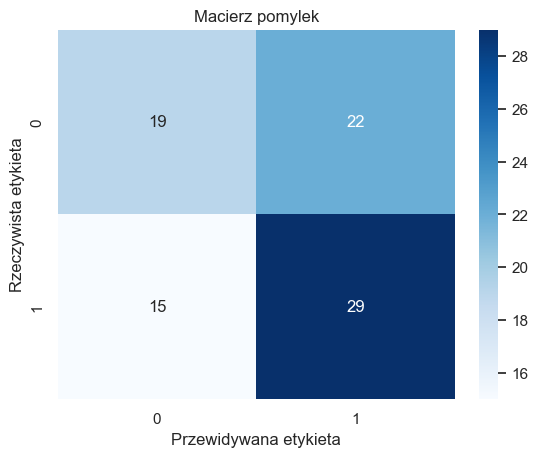

In [367]:
# Obliczanie macierzy pomylek
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Macierz pomylek')
plt.xlabel('Przewidywana etykieta')
plt.ylabel('Rzeczywista etykieta')
plt.show()

In [368]:
# Wyświetlanie wyników
print("AUC:", auc)
print("ACC:", acc)

AUC: 0.6166851441241685
ACC: 0.5647058823529412


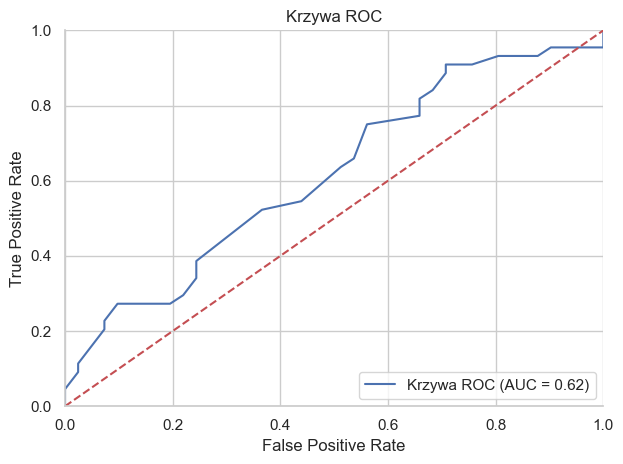

In [369]:
# Rysowanie wykresu ROC przy użyciu matplotlib
plt.figure()
plt.plot(fpr, tpr, label='Krzywa ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")

# Dodatkowe elementy wizualne z wykorzystaniem seaborn
sns.set(style="whitegrid")
sns.despine()
plt.tight_layout()

# Wyświetlanie wykresu
plt.show()